In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *
from util import *
import sys

from ctypes import *
file = "./grav.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-74
totalMassInCU = 0.1
dtInCU = 2500.0
bigT = 20000

Solving for a pure boson star
Big Lambda: 1000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.704678
A2 (0.001-15.0, check if too close to boundary values): 0.319763
Furthest solved star: 2830.87
MCU 0.84952014139742
Solving for a pure boson star
Big Lambda: 1000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.772166
A2 (0.001-15.0, check if too close to boundary values): 0.569739
Furthest solved star: 9041.23
MCU 0.17070212121143416
Solving for a pure boson star
Big Lambda: 1000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.77054
A2 (0.001-15.0, check if too close to boundary values): 0.602859
Furthest solved star: 19264.3
MCU 0.07575549924955507
Solving for a pure boson star
Big Lambda: 1000

Results of the fourth order ODE solver:
farPoint (0-1, check if too close to boundary values): 0.780558
A2 (0.001-15.0, check if too close to b

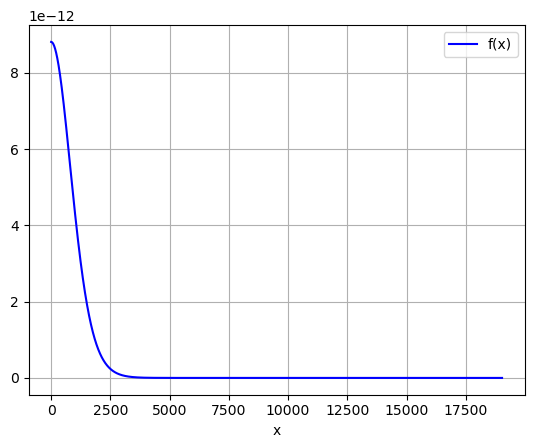

(1302,)


In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU, 4000)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

dx = x[1]-x[0]
print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 1.2233182200635002e+40
Omega: 3.6561290929984644e-42
Epsilon (Should be 1): 1.0
Delta: 4.692649123249829
New G: 0.3734291520805296


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print(dt)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
0.8351027137908527


In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -5.0/2.0 + 4.0/3.0 - 1.0/12.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i] = -1.0/2.0/x[i]
        elif i==1:
            T[i][i-1] = 4.0/3.0 -1.0/12.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]
        elif i==size-2:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0 - 1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]
        elif i==size-1:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0 + 4.0/3.0 -1.0/12.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * GM

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.01445738296193095 0.9938786500960817
1 0.8351027137908527 0.014464181832265856 0.9938786389229397
2 1.6702054275817053 0.014476221777583136 0.9938786203538932
3 2.505308141372558 0.014490214459569202 0.9938785981554992
4 3.3404108551634106 0.014504365519180934 0.993878576203155
5 4.175513568954264 0.014517951732278352 0.9938785544957854
6 5.010616282745116 0.014531470515254816 0.9938785331021016
7 5.845718996535968 0.014544391219465885 0.9938785120284579
8 6.680821710326821 0.014557087798479702 0.9938784913319494
9 7.515924424117674 0.014569164612074872 0.9938784710217381
10 8.351027137908527 0.014580906582939599 0.9938784511442371
11 9.186129851699379 0.014592024310997443 0.9938784317090006
12 10.021232565490232 0.014602735403265107 0.9938784127525206
13 10.856335279281085 0.014612835179487815 0.9938783942832621
14 11.691437993071936 0.014622488205360487 0.9938783763286054
15 12.52654070686279 0.014631557263924459 0.9938783588951089
16 13.361643420653643 0.014640163746042989 0

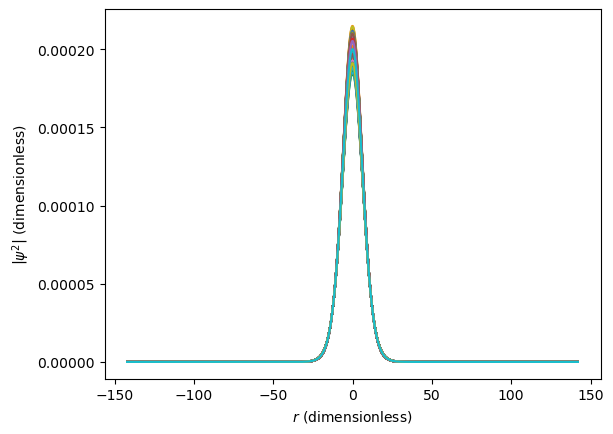

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()


#Record
gravitationalForce = []
pressureGradient = []
quantumPressure = []

hello = []
ts = []
oldGM = GM
newGM = GM*2.0
for t in range(bigT):
    #Pertubation
    if(t*dt<2.0):
        GM = newGM
    if(t*dt>=2.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    if(normalization >= 1.01):
        break
    print(t, t*dt, np.absolute(psi[size//2]), normalization)
    if(t*dt >= 10.0):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

        #Record
        rho0 = (np.absolute(psi[size//2 + 14])*np.absolute(psi[size//2 + 14]))/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[size//2 + 15])*np.absolute(psi[size//2 + 15]))/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[size//2 + 16])*np.absolute(psi[size//2 + 16]))/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[size//2 + 17])*np.absolute(psi[size//2 + 17]))/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[size//2 + 16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        gravitationalForce.append((phi[size//2 + 16]-phi[size//2 + 15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
#plt.savefig('profile_'+sys.argv[1]+'.png')
plt.show()

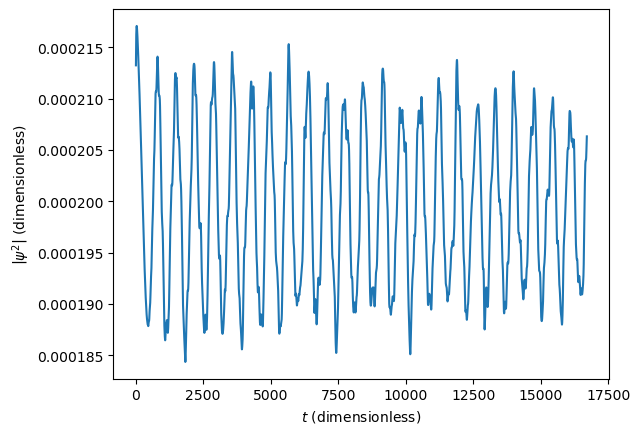

In [8]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
#plt.savefig('central_density'+sys.argv[1]+'.png')
plt.show()

Text(0.5, 0, 'f (1/s)')

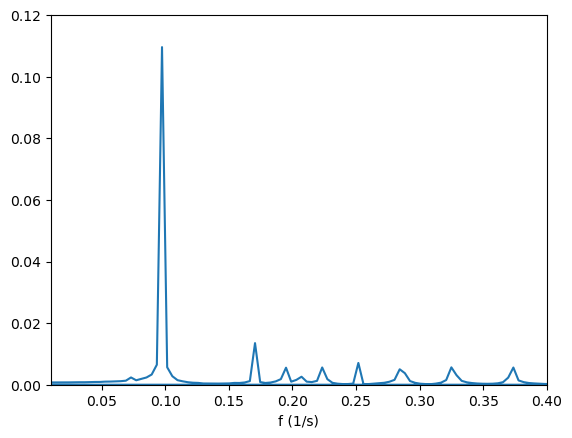

In [15]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,0.12)
#plt.savefig('fourierTransform'+sys.argv[1]+'.png')
plt.xlabel("f (1/s)")

In [10]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.001 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.004062777666599959
0.07312999799879927 0.00235902909614635
0.09750666399839904 0.10961043051843244
0.17063666199719832 0.013506271811804305
0.19501332799679807 0.005531492420726042
0.20720166099659798 0.002593165205606464
0.2234527716629978 0.005603760709526025
0.25189221532919753 0.0070707215454298205
0.2843944366619972 0.0050146611166139955
0.3250222133279968 0.005640106081138704
0.3737755453271963 0.005584871021322702
0.4225288773263958 0.0035176995561401686
0.48347054232539527 0.003558910281975413
0.5444122073243945 0.004328622505787422
0.613479427656594 0.003497119078889332
0.6866094256553933 0.0032713783542210706
0.7638022013207925 0.0025179819158720734
0.8491205323193917 0.0023407695467342646
0.9385016409845908 0.001858629250690675
1.0319455273163898 0.0014799553515340285
1.1335149689813888 0.001096427615595296


[1.57426085e-06 1.57380617e-06 1.57285902e-06 ... 1.57285902e-06
 1.57380617e-06 1.57426085e-06]


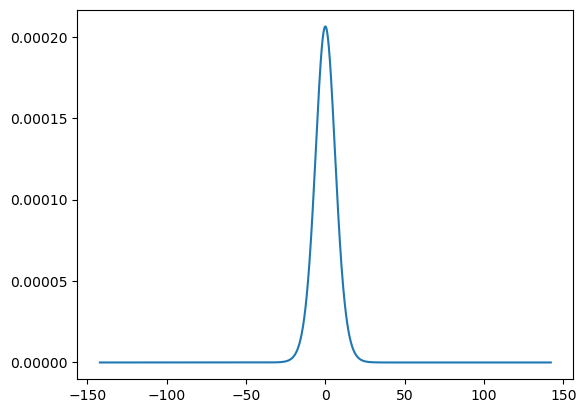

In [11]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?

In [12]:
print(psi)

[-5.18383406e-07-1.48646422e-06j -5.18282927e-07-1.48601772e-06j
 -5.18091694e-07-1.48508130e-06j ... -5.18091694e-07-1.48508130e-06j
 -5.18282927e-07-1.48601772e-06j -5.18383406e-07-1.48646422e-06j]


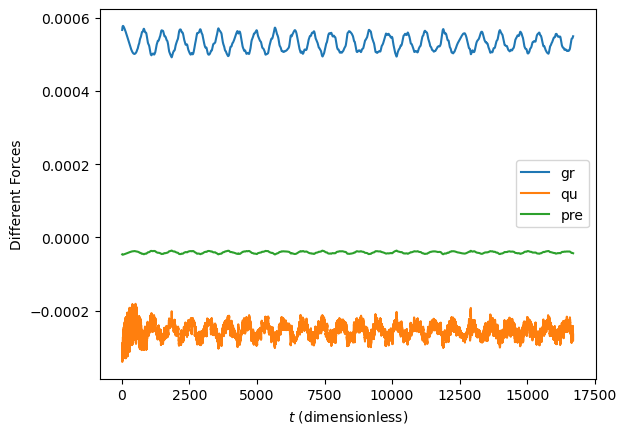

In [13]:
plt.plot(ts, gravitationalForce)
plt.plot(ts, quantumPressure)
plt.plot(ts, pressureGradient)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.legend(['gr','qu','pre'])
#plt.savefig('force'+sys.argv[1]+'.png')
plt.show()